In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
#Kaggle - https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/data
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
berkanoztas_synthetic_transaction_monitoring_dataset_aml_path = kagglehub.dataset_download('berkanoztas/synthetic-transaction-monitoring-dataset-aml')

print('Data source import complete.')


100%|██████████| 193M/193M [00:02<00:00, 97.8MB/s]

Extracting files...


Data source import complete.


In [2]:
pip install seaborn

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('SAML-D.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (9504852, 12)


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [11]:
transactions_per_payment_type = df['Payment_type'].value_counts()
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()
transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Credit card        2012909
 Debit card         2012103
 Cheque             2011419
 ACH                2008807
 Cross-border        933931
 Cash Withdrawal     300477
 Cash Deposit        225206
 Name: count, dtype: int64,
 Payment_type
 ACH                1159
 Cash Deposit       1405
 Cash Withdrawal    1334
 Cheque             1087
 Credit card        1136
 Cross-border       2628
 Debit card         1124
 dtype: int64)

In [12]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     1.261850e+07
mean    4.058767e+04
min     1.582000e+01
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     999962.190000
mean      8729.875874
min          3.730000
Name: Amount, dtype: float64


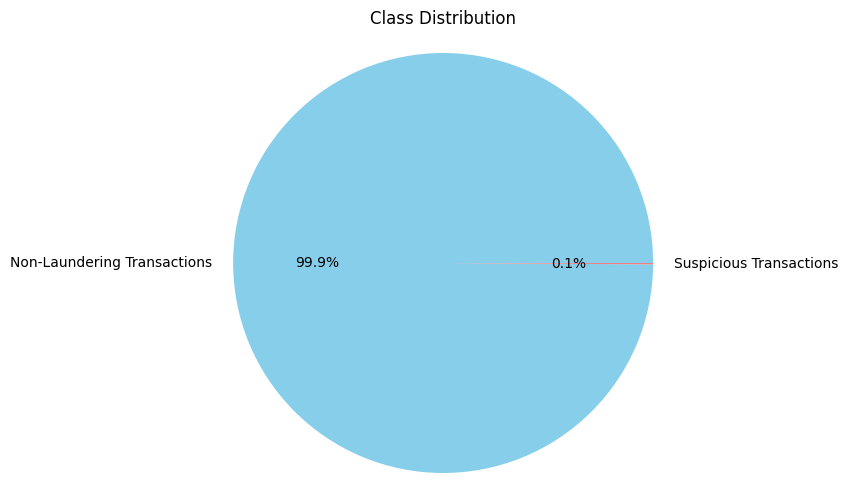

In [13]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

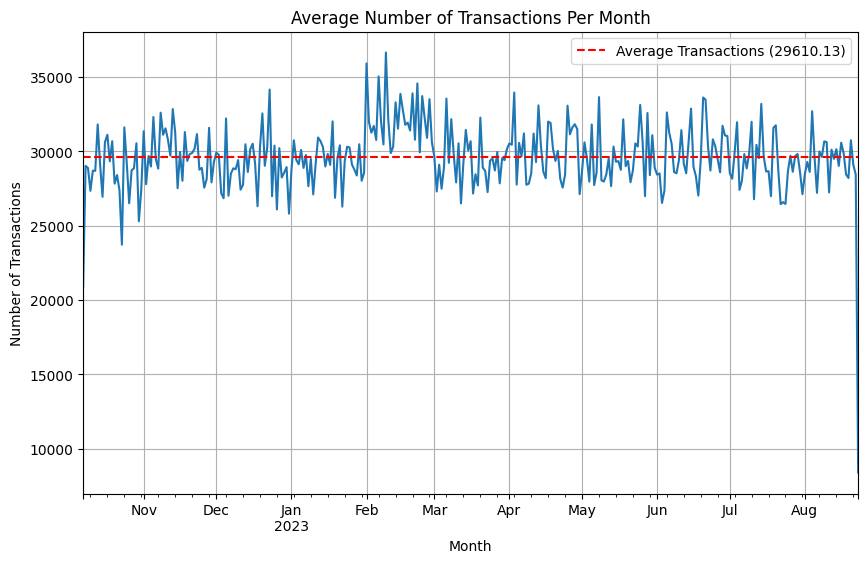

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
monthly_transactions = df.groupby(df['Date'].dt.to_period('D')).size()


average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show()

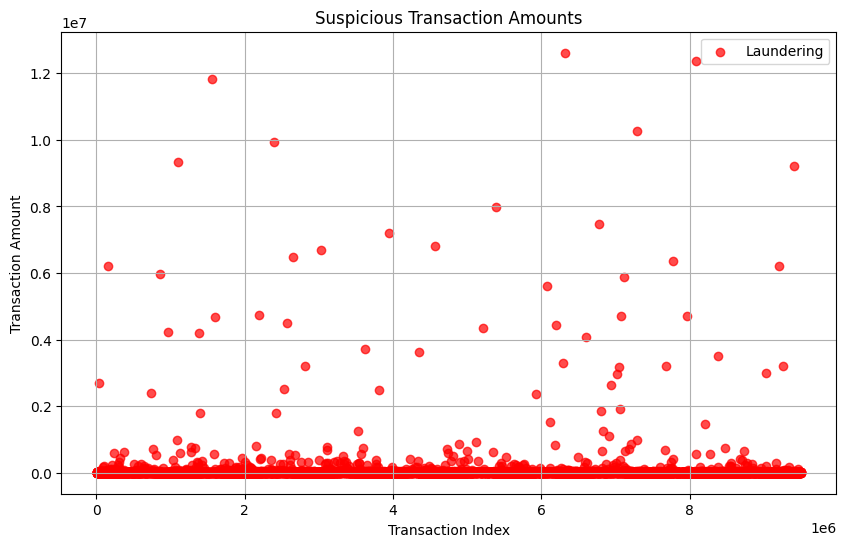

In [15]:
laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='red', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Number of Alerts')

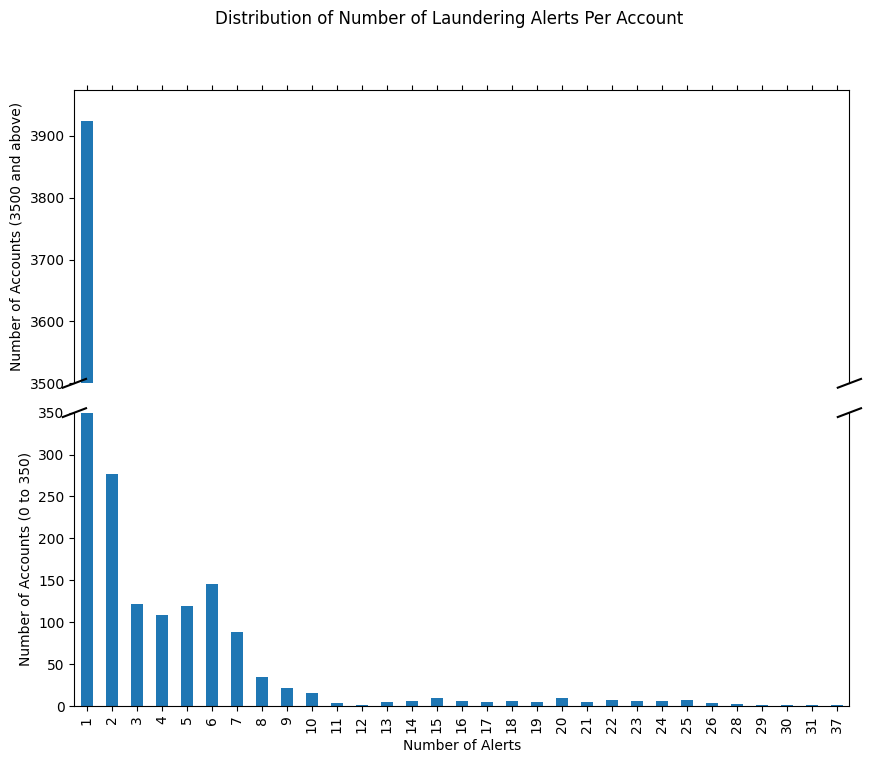

In [16]:
laundering_df = df[df['Is_laundering'] == 1]

account_alert_counts = laundering_df.groupby('Sender_account').size()
alert_distribution = account_alert_counts.value_counts()
alert_distribution = alert_distribution.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.1)

alert_distribution.plot(kind='bar', ax=ax1)
alert_distribution.plot(kind='bar', ax=ax2)

fig.suptitle('Distribution of Number of Laundering Alerts Per Account')

ax1.set_ylim(3500, alert_distribution.max()+50)
ax2.set_ylim(0, 350)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015  # diagonal lines size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax2.set_ylabel('Number of Accounts (0 to 350)')
ax1.set_ylabel('Number of Accounts (3500 and above)')
ax2.set_xlabel('Number of Alerts')

Original Skewness: 102.16408577285024
Log-Transformed Skewness: -1.0103052224946008


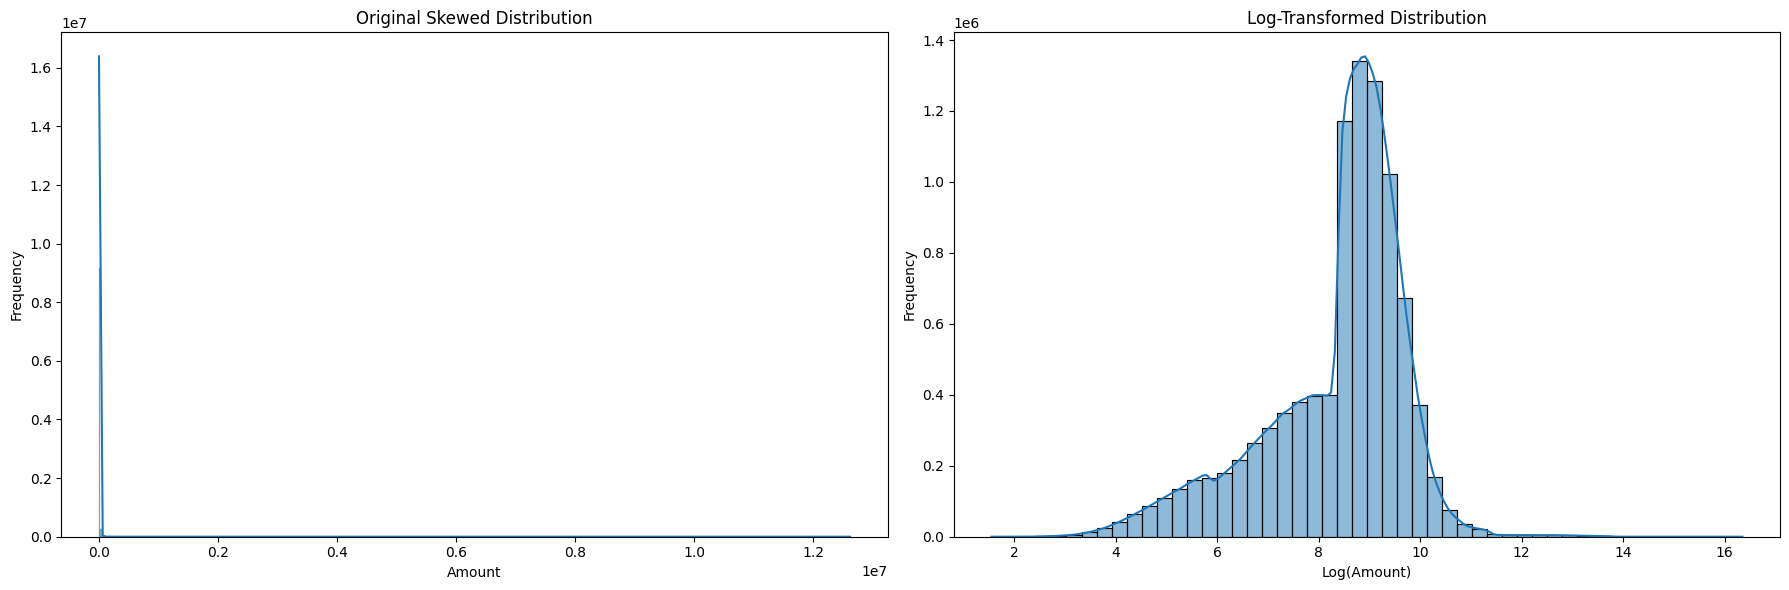

In [17]:
skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

styled_combined_pivot

<ipython-input-18-97d6f05ccccc>:1: FutureWarning: The provided callable <function sum at 0x7c1e775e8cc0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)


,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,18272052011.854218,1159,2007648
Cash Deposit,485809045.640000,1405,223801
Cash Withdrawal,46118125.580000,1334,299143
Cheque,18328875956.816402,1087,2010332
Credit card,18308924931.183823,1136,2011773
Cross-border,9476591292.695444,2628,931303
Debit card,18372338763.838520,1124,2010979


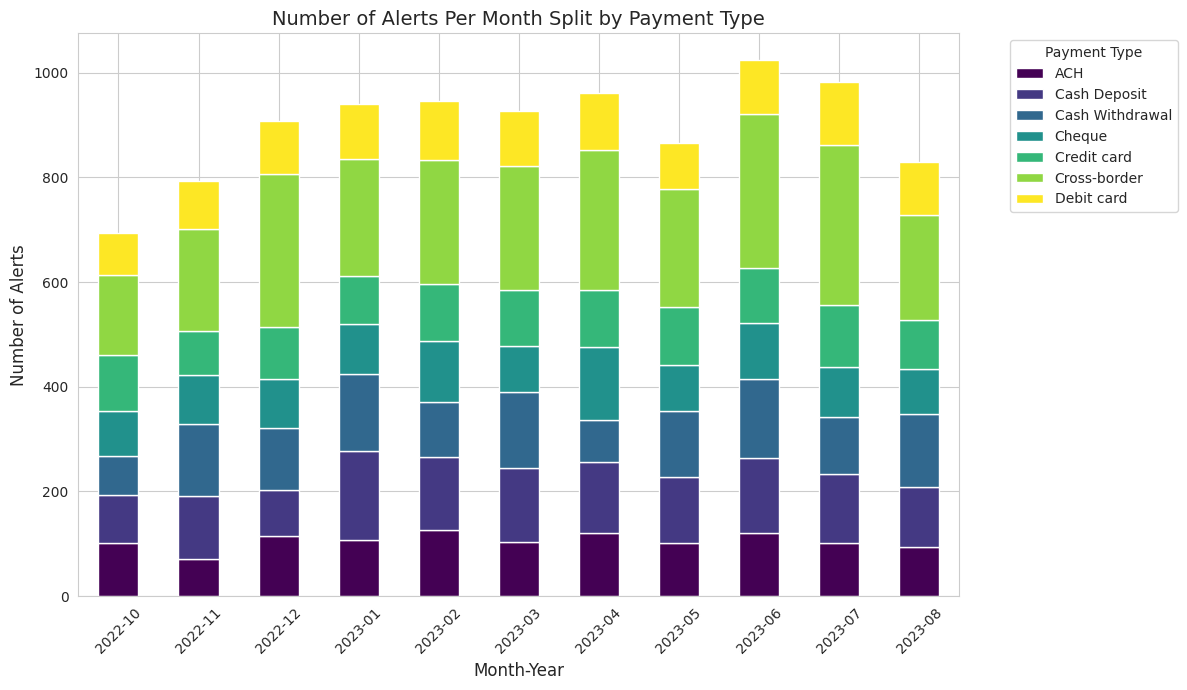

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

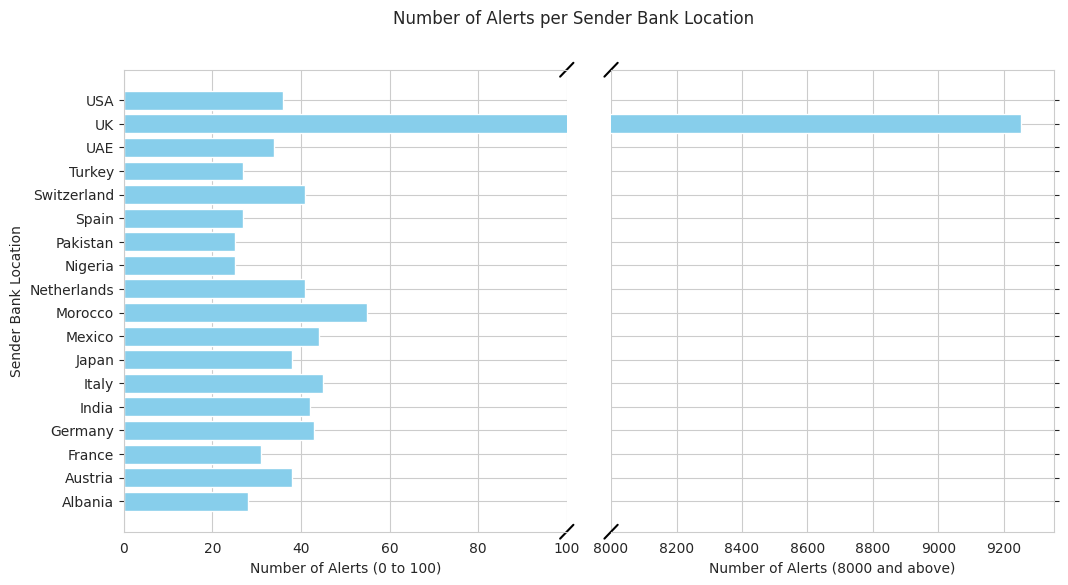

In [20]:
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)

ax1.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')

ax1.set_xlim(0, 100)  # Set the left subplot values
ax2.set_xlim(8000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Sender Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (8000 and above)')
ax1.set_ylabel('Sender Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Sender_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Sender_bank_location'])

plt.show()

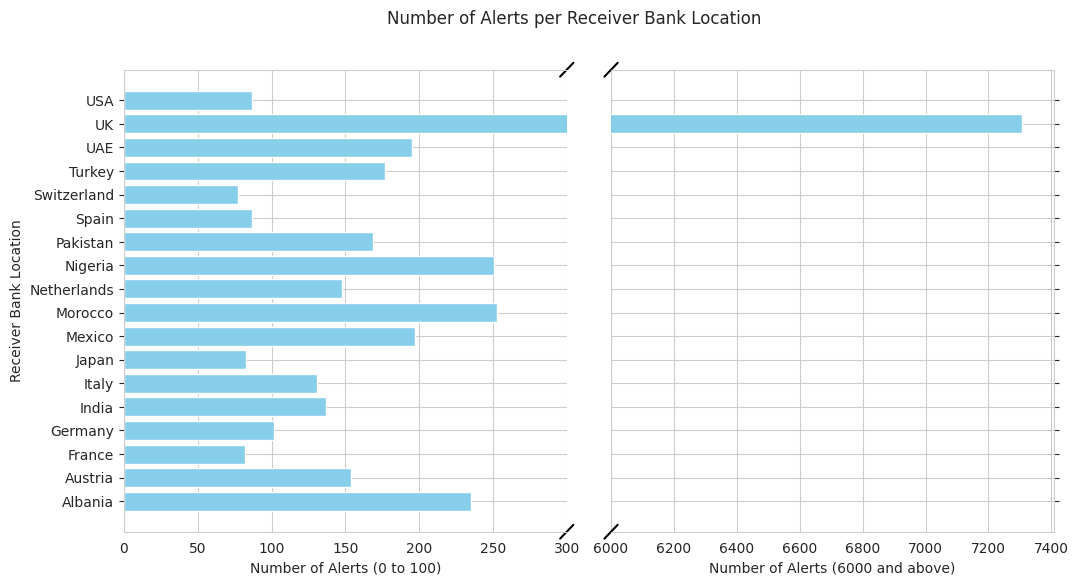

In [21]:
alerts_per_location = df.groupby('Receiver_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

ax1.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')

ax1.set_xlim(0, 300)  # Set the left subplot values
ax2.set_xlim(6000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Receiver Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (6000 and above)')
ax1.set_ylabel('Receiver Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Receiver_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Receiver_bank_location'])

plt.show()

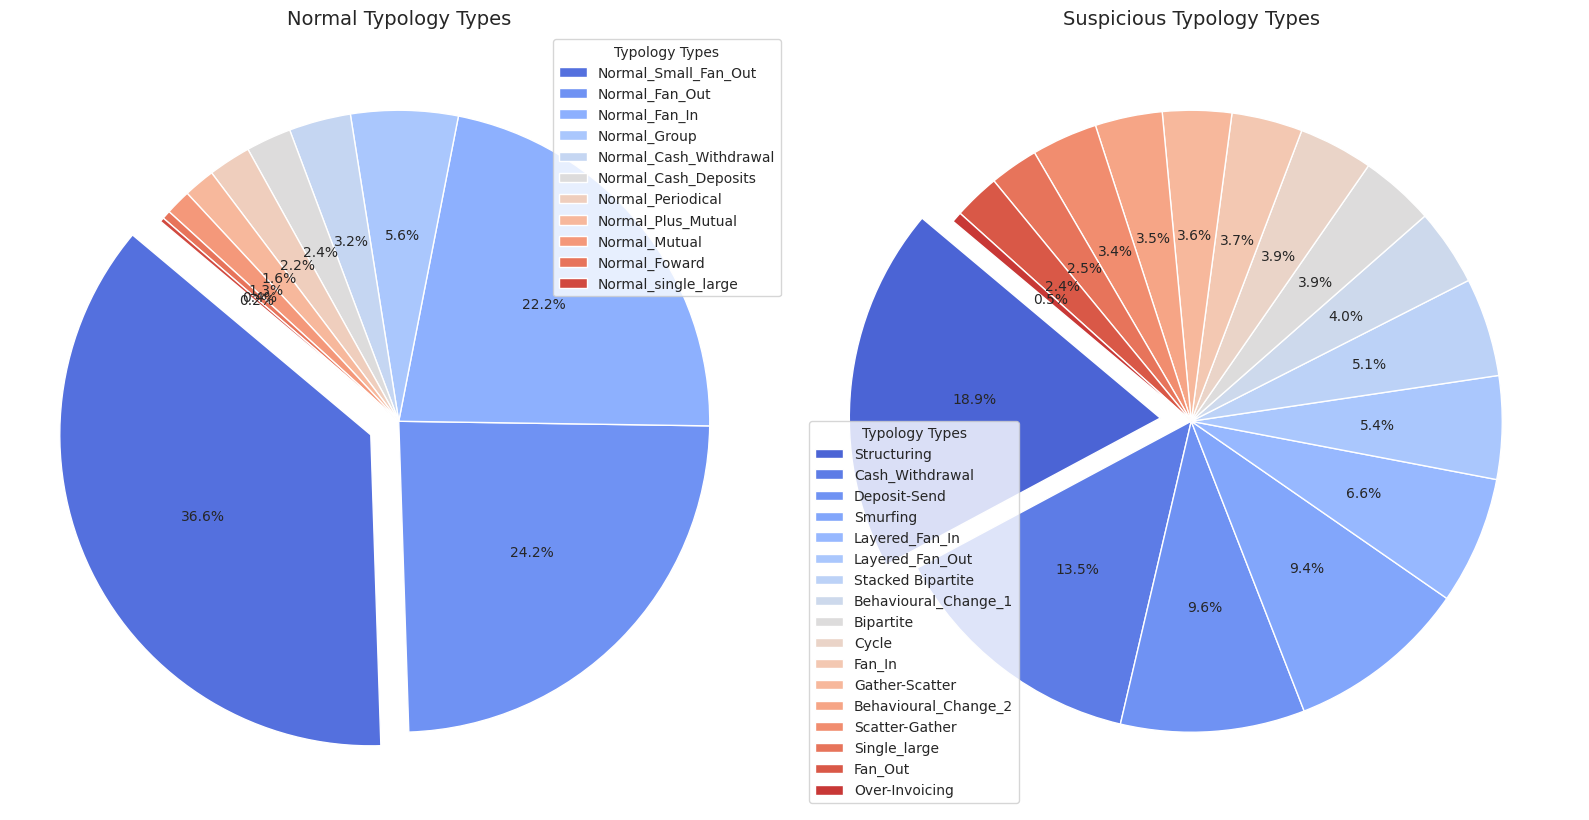

In [22]:
normal_data = df[df['Is_laundering'] == 0]['Laundering_type'].value_counts()
laundering_data = df[df['Is_laundering'] == 1]['Laundering_type'].value_counts()

# palette_normal = sns.color_palette("husl", len(normal_data))
palette_normal = sns.color_palette("coolwarm", len(normal_data))
palette_laundering = sns.color_palette("coolwarm", len(laundering_data))

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

explode_normal = [0.1] + [0] * (len(normal_data) - 1)
explode_laundering = [0.1] + [0] * (len(laundering_data) - 1)

patches, texts, autotexts = axs[0].pie(normal_data, explode=explode_normal, autopct='%1.1f%%', colors=palette_normal, startangle=140)
axs[0].set_title('Normal Typology Types', fontsize=14)
axs[0].legend(patches, normal_data.index, loc='best', title="Typology Types", fontsize=10)

patches, texts, autotexts = axs[1].pie(laundering_data, explode=explode_laundering, autopct='%1.1f%%', colors=palette_laundering, startangle=140)
axs[1].set_title('Suspicious Typology Types', fontsize=14)
axs[1].legend(patches, laundering_data.index, loc='best', title="Typology Types", fontsize=10)

for text in texts + autotexts:
  text.set_fontsize(10)

plt.tight_layout()
plt.show()

In [24]:
df = pd.read_csv('SAML-D.csv')

In [25]:
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

df['Date_Year'] = pd.to_datetime(df['Date']).dt.year
df['Date_Month'] = pd.to_datetime(df['Date']).dt.month
df['Date_Day'] = pd.to_datetime(df['Date']).dt.day

df.drop(columns=['Laundering_type'], inplace=True)
df.drop(columns=['Time', 'Date'], inplace=True)

<ipython-input-25-40ca10c31d52>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [26]:
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

df['Amount'] = log_transformed_data

Original Skewness: 102.16408577285024
Log-Transformed Skewness: -1.0103052224946008


In [27]:
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_currency', 'Received_currency',
                   'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
                   'Date_Year', 'Date_Month', 'Date_Day']

for col in categorical_cols:
    encoder = preprocessing.LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

numerical_cols = ['Hour', 'Amount']

scaler = preprocessing.StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Hour,Date_Year,Date_Month,Date_Day
0,255277,180462,-0.756957,10,10,16,16,1,0,-0.732897,0,8,6
1,43554,548141,0.253092,10,1,16,15,5,0,-0.732897,0,8,6
2,8553,287765,0.871335,10,10,16,16,3,0,-0.732897,0,8,6
3,157249,626370,0.738639,10,10,16,16,0,0,-0.732897,0,8,6
4,281324,248338,-2.561195,10,10,16,16,1,0,-0.732897,0,8,6


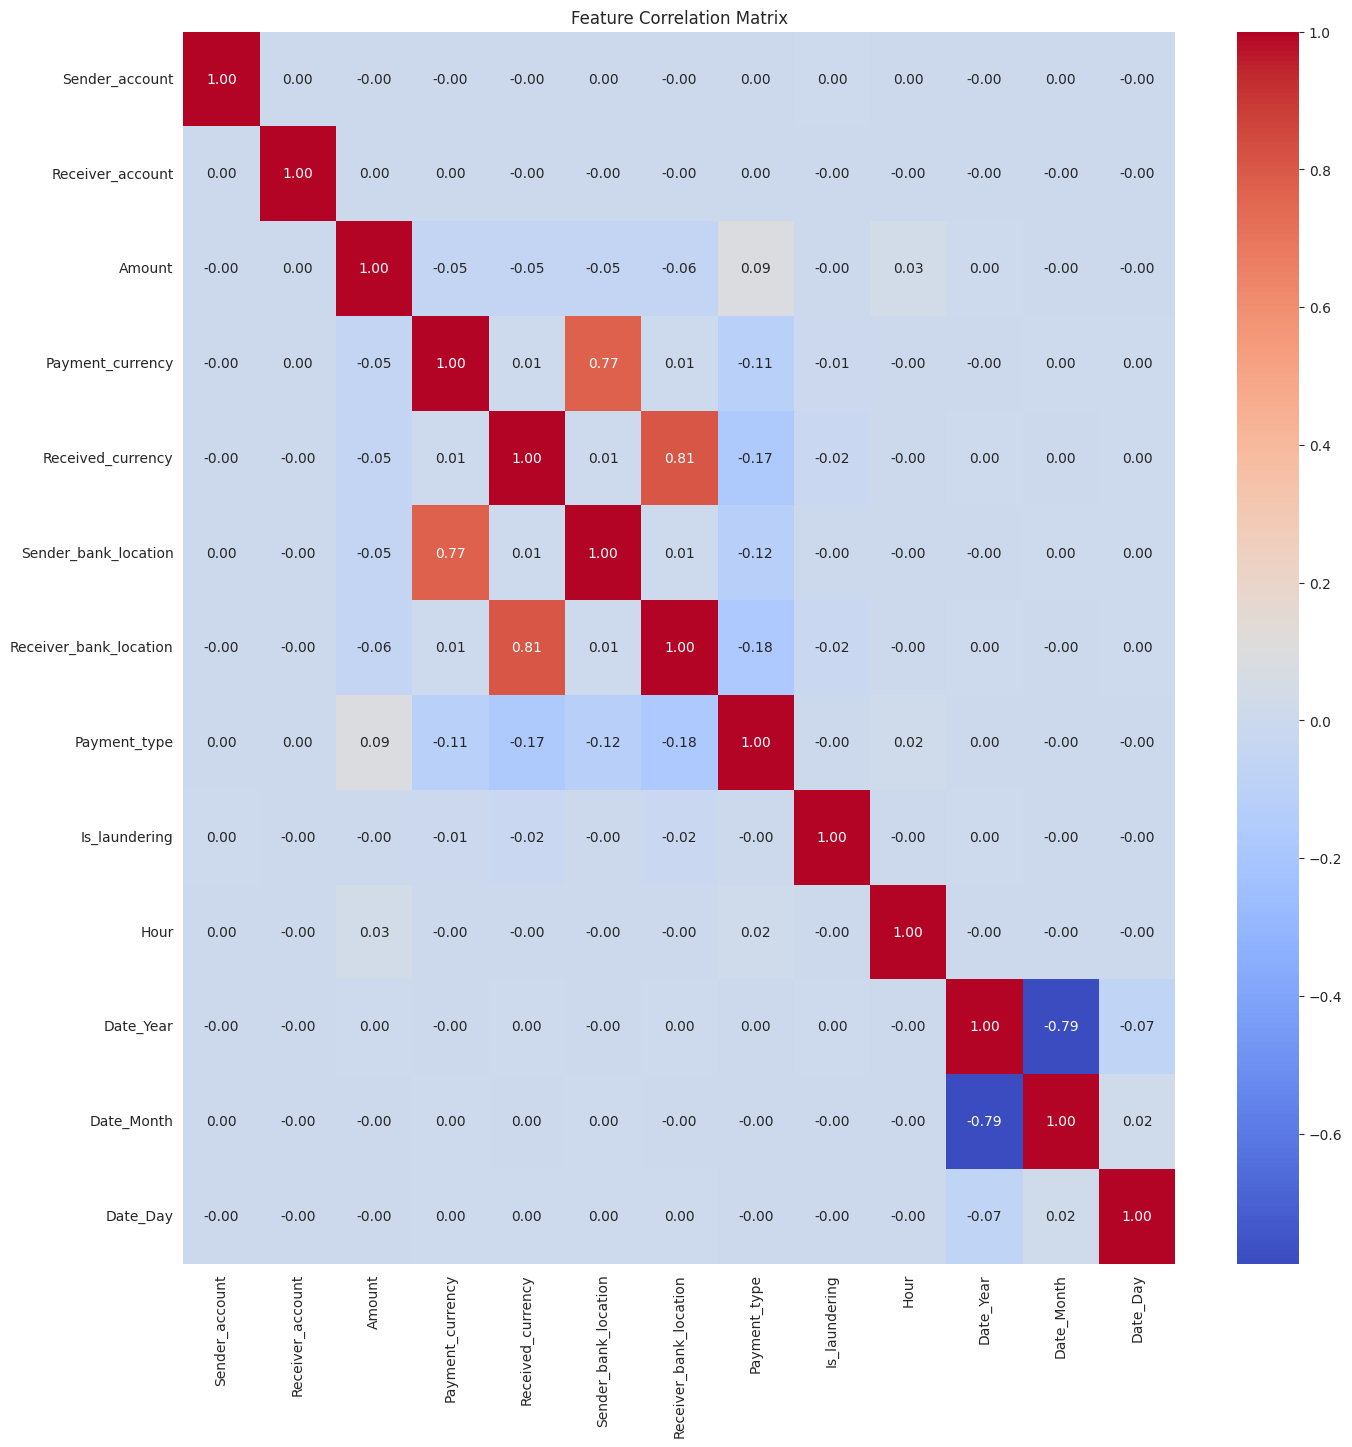

In [28]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

In [29]:
X = df.drop(columns=['Is_laundering'])
y = df['Is_laundering']

In [30]:
total_size = len(df)
train_size = int(0.8 * total_size)
test_and_validation_size = total_size - train_size
test_size = int(0.5 * test_and_validation_size)
validation_size = test_and_validation_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_validation = X[train_size:train_size+test_size]
y_validation = y[train_size:train_size+test_size]

X_test = X[train_size+test_size:]
y_test = y[train_size+test_size:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape)

(7603881, 12) (7603881,) (950486, 12) (950486,) (950485, 12) (950485,)


In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    # 'max_depth': [4,8,16],
    # 'eta': [0.1,0.2,0.3],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

val_predictions = best_model.predict_proba(X_validation)[:, 1]
val_auc = roc_auc_score(y_validation, val_predictions)
print("Validation AUC: ", val_auc)

test_predictions = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)
print("Test AUC: ", test_auc)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................................................... total time=  27.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................................................... total time=  27.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:  {}
Validation AUC:  0.8271847313025383
Test AUC:  0.8120470486529636


Test Set AUC:  0.8120470486529636


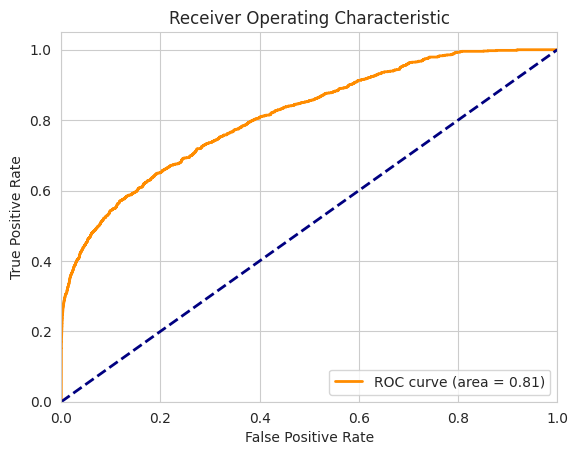

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

test_probabilities = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probabilities)
print("Test Set AUC: ", test_auc)

fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Desired TPR of around 90%:


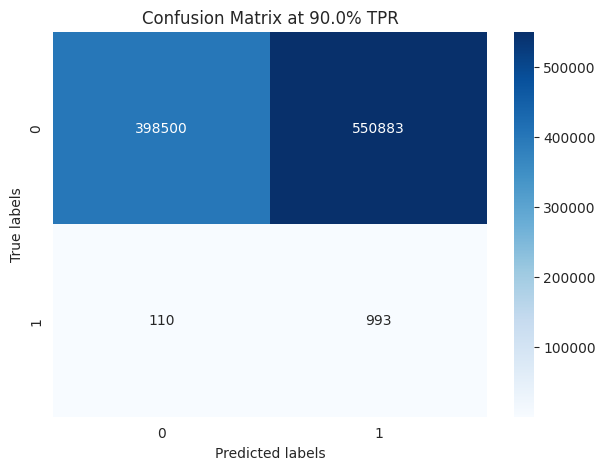

False Positive Rate (FPR): 0.580
True Positive Rate (TPR): 0.900


In [33]:
desired_tpr = 0.9
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Desired TPR of around 90%:")

y_pred = (test_probabilities >= closest_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix at {desired_tpr*100}% TPR')
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)

print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")